In [1]:
# choose embedding from ['random', 'senna']
EMBEDDING_TYPE = 'senna'

# choose model from ['lstm', 'lstm_crf', 'crf', 'bi_lstm', 'bi_lstm_crf']
MODEL = 'bi_lstm_crf'

# hyper parameters
BATCH_SIZE = 512  # Number of examples used in each iteration
EPOCHS = 3  # Number of passes through entire dataset
MAX_LEN = 75  # Max length of review (in words)
EMBEDDING = 50  # Dimension of word embedding vector
HIDDEN = 300
LR = 0.1

In [2]:
!pip install datasets Keras-Preprocessing tensorflow-addons seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

In [4]:
# Load CoNLL2003 dataset
from datasets import load_dataset
import numpy as np
data = load_dataset("conll2003")
print(data)

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [5]:
train_data = data['train']
val_data = data['validation']
test_data = data['test']
print(train_data.features)

{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None), 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}


In [6]:
### build tag vocabulary from ner_tags
tags = train_data.features['ner_tags'].feature.names
n_tags = len(tags)

# The first entry is reserved for PAD
tag2idx = {t : i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

idx2tag = {i: t for t, i in tag2idx.items()}

print(tag2idx)

{'O': 1, 'B-PER': 2, 'I-PER': 3, 'B-ORG': 4, 'I-ORG': 5, 'B-LOC': 6, 'I-LOC': 7, 'B-MISC': 8, 'I-MISC': 9, 'PAD': 0}


In [ ]:
# build word vocabulary from senna words.lst

words = []
for l in open(f'senna/words.lst', 'r+'):
  words.append(l.rstrip('\n'))

n_words = len(words)

# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

idx2word = {i: w for w, i in word2idx.items()}

In [22]:
# save senna idx2word and idx2tag for highlighter server
import joblib
joblib.dump(idx2word, 'senna/senna_idx2word.pkl')
joblib.dump(idx2tag, 'senna/senna_idx2tag.pkl')

['senna_idx2tag.pkl']

In [8]:
# assign random 50-dim vector for PAD and UNK
pad_embedding = np.around(2 * np.random.rand(1, 50) - 1, decimals=5)
unk_embedding = np.around(2 * np.random.rand(1, 50) - 1, decimals=5)

# build senna embedding matrix from senna embeddings.txt
senna_embedding_matrix = [list(pad_embedding[0]), list(unk_embedding[0])]

for l in open(f'senna/embeddings.txt', 'r+'):
  senna_embedding_matrix.append([float(x) for x in l.rstrip('\n').split(' ')])

In [9]:
# build random embedding matrix
# each entry is (-1, 1)
random_embedding_matrix = []
for i in range(130002):
  random_embedding_matrix.append(list(np.around(2 * np.random.rand(1, 50) - 1, decimals=5)[0]))

In [10]:
np.array(senna_embedding_matrix).shape

(130002, 50)

In [12]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


def build_dataset(sents, tags):
  # Convert each sentence from list of Token to list of word_index
  X = []
  for s in sents:
    Xx = []
    for w in s:
      try:
        Xx.append(word2idx[w.lower()])
      except:
        Xx.append(word2idx['UNK'])
    X.append(Xx)

  # Padding each sentence to have the same lenght
  X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

  # add 1 to tag for PAD token
  y = [[t+1 for t in s] for s in tags]

  # Padding each sentence to have the same lenght
  y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

  # One-Hot encode
  y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

  return X, y

In [13]:
X_tr, y_tr = build_dataset(train_data['tokens'], train_data['ner_tags'])

print('Raw Sample: ', ' '.join([w for w in train_data['tokens'][0]]))
print('Raw Label: ', ' '.join([idx2tag[t+1] for t in train_data['ner_tags'][0]]))
print('After processing, sample:', X_tr[0])
print('After processing, labels:', y_tr[0][0])

Raw Sample:  EU rejects German call to boycott British lamb .
Raw Label:  B-ORG O B-MISC O O O B-MISC O O
After processing, sample: [ 38606  96443  46071  18595 117096  15926  16691  64654    695      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0]
After processing, labels: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [14]:
X_val, y_val = build_dataset(val_data['tokens'], val_data['ner_tags'])
X_te, y_te = build_dataset(test_data['tokens'], test_data['ner_tags'])

In [15]:
from keras.models import Model, Sequential
from keras import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.layers import CRF
import keras as k

match EMBEDDING_TYPE:
  case 'random':
    embedding_matrix = random_embedding_matrix
  case 'senna':
    embedding_matrix = senna_embedding_matrix

match MODEL:
  case 'bi_lstm_crf':
    input = Input(shape=(MAX_LEN,))
    model = Embedding(input_dim=n_words+2,
                      output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                      input_length=MAX_LEN,
                      mask_zero=True,
                      embeddings_initializer=k.initializers.Constant(embedding_matrix),
                      trainable=False)(input)
    model = Bidirectional(LSTM(units=HIDDEN, return_sequences=True, recurrent_dropout=0.1))(model)
    crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
    _, out, _, _ = crf(model)  # output
    model = Model(input, out)

  case 'bi_lstm':
    model = Sequential()
    model.add(Embedding(input_dim=n_words+2,
                        output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                        input_length=MAX_LEN,
                        mask_zero=True,
                        embeddings_initializer=k.initializers.Constant(embedding_matrix),
                        trainable=False))
    model.add(Bidirectional(LSTM(units=HIDDEN, return_sequences=True, recurrent_dropout=0.1)))
    model.add(Dense(n_tags+1, activation="softmax"))

  case 'lstm':
    model = Sequential()
    model.add(Embedding(input_dim=n_words+2,
                        output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                        input_length=MAX_LEN,
                        mask_zero=True,
                        embeddings_initializer=k.initializers.Constant(embedding_matrix),
                        trainable=False))

    model.add(LSTM(units=HIDDEN, return_sequences=True, recurrent_dropout=0.1))
    model.add(Dense(n_tags+1, activation="softmax"))

  case 'lstm_crf':
    input = Input(shape=(MAX_LEN,))
    model = Embedding(input_dim=n_words+2,
                      output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                      input_length=MAX_LEN,
                      mask_zero=True,
                      embeddings_initializer=k.initializers.Constant(embedding_matrix),
                      trainable=False)(input)  # TODO: change to senna embedding
    model = LSTM(units=HIDDEN, return_sequences=True, recurrent_dropout=0.1)(model)
    crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
    _, out, _, _ = crf(model)  # output
    model = Model(input, out)

  case 'crf':
    input = Input(shape=(MAX_LEN,))
    model = Embedding(input_dim=n_words+2,
                      output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                      input_length=MAX_LEN,
                      mask_zero=True,
                      embeddings_initializer=k.initializers.Constant(embedding_matrix),
                      trainable=False)(input)
    crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
    _, out, _, _ = crf(model)  # output
    model = Model(input, out)

print('embedding type is ', EMBEDDING_TYPE + ', model type is ' + MODEL)
model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


embedding type is  senna, model type is bi_lstm_crf
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding (Embedding)       (None, 75, 50)            6500100   
                                                                 
 bidirectional (Bidirectiona  (None, 75, 600)          842400    
 l)                                                              
                                                                 
 crf (CRF)                   [(None, 75),              6130      
                              (None, 75, 10),                    
                              (None,),                           
                              (10, 10)]                          
                                                                 
Total par

In [17]:
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from keras import backend as K

if 'crf' in MODEL:
  print('with crf layer')
  model.compile(optimizer='rmsprop', loss=SigmoidFocalCrossEntropy(), metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, LR)
else:
  print('without crf layer')
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, LR)

with crf layer


In [18]:
history = model.fit(X_tr, np.array(y_tr), validation_data=(X_val, np.array(y_val)), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Epoch 1/3


28/28 [==============================] - 35s 717ms/step - loss: 337.8515 - accuracy: 0.8918 - val_loss: 6.7533 - val_accuracy: 0.9704
Epoch 2/3
28/28 [==============================] - 19s 657ms/step - loss: 15.1902 - accuracy: 0.9678 - val_loss: 1.8096 - val_accuracy: 0.9766
Epoch 3/3
28/28 [==============================] - 18s 634ms/step - loss: 28.1468 - accuracy: 0.9658 - val_loss: 7.2826 - val_accuracy: 0.9797


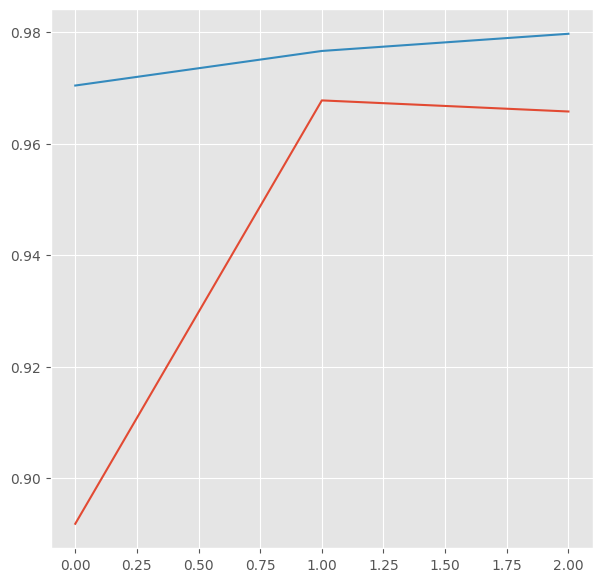

In [19]:
import pandas as pd
hist = pd.DataFrame(history.history)

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(7, 7))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

In [20]:
# print prediction
i = 2

p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w-1], idx2tag[t], idx2tag[pred]))


1/1 [==============================] - 1s 1s/step
Word           ||True ||Pred
al-ahram       : B-LOC B-LOC
+unq           : O     O
unitech        : B-LOC B-LOC
ara            : I-LOC B-LOC
emirate        : I-LOC I-ORG
PAD            : O     O


In [21]:
#evaluate model
score = model.evaluate(X_te, np.array(y_te), verbose=1)

108/108 [==============================] - 6s 59ms/step - loss: 6.6610 - accuracy: 0.9811


In [23]:
# save model locally
model_name = EMBEDDING_TYPE + '_' + MODEL + '.tf'
model.save(model_name)

In [24]:
!zip -r /content/{model_name}.zip /content/{model_name}

  adding: content/senna_bi_lstm_crf.tf/ (stored 0%)
  adding: content/senna_bi_lstm_crf.tf/fingerprint.pb (stored 0%)
  adding: content/senna_bi_lstm_crf.tf/variables/ (stored 0%)
  adding: content/senna_bi_lstm_crf.tf/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/senna_bi_lstm_crf.tf/variables/variables.index (deflated 59%)
  adding: content/senna_bi_lstm_crf.tf/assets/ (stored 0%)
  adding: content/senna_bi_lstm_crf.tf/keras_metadata.pb (deflated 61%)
  adding: content/senna_bi_lstm_crf.tf/saved_model.pb (deflated 90%)
